# UAVNOMA Tutorial

1. Introduction
2. Generates simulation parameters
4. Calculates performance metrics
5. Plots of the performance metrics

## Introduction

Non-orthogonal multiple access (NOMA) has been widely pointed out as a promising candidate to multiple access technology of the next generation of wireless networks due to its potential in achieving high spectral efficiency, connectivity, and low latency. The combination of the NOMA technique with unmanned aerial vehicles (UAV) allows segments to support diverse applications required by the next generations of mobile communications, improving the connectivity and coverage of terrestrial wireless devices.

We consider that an UAV is deployed as an air base station that communicates  with M=2 users of different channel conditions, as illustrated in the figure below.


![System model.](../figures/uav_system_model_ex.png)

The *uavnoma* package was proposed as a tool for the user to study the modeling of a UAV-NOMA network and use it as a basis for implementing other technologies. To understand how the package works, this tutorial introduces the structure and functionality of the package. The package contains functions for modeling wireless communication between an area base station and two users using NOMA. Specifically, we implement functions to:

1. Modeling the simulation parameters
2. Modeling users' and UAV's location
3. Model the communication channel
4. Calculate SINR
5. Calculate performance metrics: achievable rate and outage probability






## Generates simulation parameters

Load packages 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uavnoma

Set up of simulation parameters. The user can modify the parameters to analyze the system performance.

In [3]:
# Variable simulation parameters
monte_carlo_samples = 100000  # Monte Carlo samples
power_los = 1.0 # power of Line-of-Sigth path & scattered paths (1<= power_los <= 2)
rician_factor = 15 # Rician factor value (10<= rician_factor <= 15)
path_loss = 2.2 # Path loss exponent (2.0 <= path_loss <= 3.0)
snr_dB = np.array(range(10, 61, 2)) # SNR in dB
snr_linear = 10.0 ** (snr_dB / 10.0)  # SNR linear
radius_uav = 2.0 # Radius fly trajectory of the UAV in meters
radius_user = 10.0  # Distribution radius of users in the cell in meters.
uav_heigth_mean = 15.0 # Average flight height
target_rate_primary_user = 0.5 # Target rate bits/s/Hertz  primary user
target_rate_secondary_user = 0.5 # Target rate bits/s/Hertz  secondary user
hardw_ip = 0.0 # Residual Hardware Impairments
sic_ip = 0.0  # Residual Imperfect SIC

# fixed simulation parameters
number_user = 2 # Number of users
number_uav = 1 # Number of UAV

Initialization of some auxiliary arrays to store the values of outage probability, achievable rate of the users, and average achievable rate of the system

In [5]:
out_probability_system = np.zeros((monte_carlo_samples, len(snr_dB)))
out_probability_secondary_user = np.zeros((monte_carlo_samples, len(snr_dB)))
out_probability_primary_user = np.zeros((monte_carlo_samples, len(snr_dB)))
system_average_rate = np.zeros((monte_carlo_samples, len(snr_dB)))
rate_secondary_user = np.zeros((monte_carlo_samples, len(snr_dB)))
rate_primary_user = np.zeros((monte_carlo_samples, len(snr_dB)))

Initialization of power allocation coefficient values. Initially the values are obtained manually by the user of the package. Note that the ideal is to provide more power to the user with the worst channel conditions, in our case the primary user. According to NOMA principles, the sum of the coefficients must be greater than 0 and less than or equal to 1 [0 <sum(power) <= 1].

In [6]:
# Fixed power allocation
power_coeff_primary, power_coeff_secondary = uavnoma.generate_power_coeff()
print('Power allocation coefficient for primary user: ',  power_coeff_primary)
print('Power allocation coefficient for secondary user: ',  power_coeff_secondary)

The sum of powers must be: [0 <sum(power) <= 1], 
 AND the power of the primary user must be greater than that of the secondary in order for their QoS to be satisfied. E.g. Primary user = 0.8 and Secondary user = 0.2.

Power allocation coefficient for primary user:  0.8
Power allocation coefficient for secondary user:  0.19999999999999996


## Calculates performance metrics

The simulations results are provided to discuss and evaluate the impact of the simulator. The impact is verified by extensive Monte Carlo simulations.

In summary, the developed functions are used for the following purpose:

* random_position_uav(): calculates the 3D position of the UAV considering a radius `radius_uav` and a height that can vary between `uav_heigth_mean` - 5 and `uav_heigth_mean`+ 5.
* random_position_users(): calculates the 2D positions of users considering a radius `radius_user`.
* fading_rician(): calculates the mean `s` and standard deviation `sigma` to model fading from the Rician distribution
* generate_channel(): generates the channel gains of the primary user `channel_gain_primary` and secondary user `channel_gain_secondary` over Rician Fading.
* calculate_instantaneous_rate_primary(): calculates the instantaneous achievable rate of the primary user `rate_primary_user` for each SNR value.
* calculate_instantaneous_rate_secondary(): calculates the instantaneous achievable rate of the secondary user `rate_primary_user` for each SNR value.
* average_rate(): calculates the average achievable rate of the system `system_average_rate` for each SNR value.
* outage_probability(): the outage probability for the system `out_probability_system`, primary user ` out_probability_primary_user`, and secondary user `out_probability_secondary_user` for each SNR value.

In [7]:
for mc in range(monte_carlo_samples):
    # Position UAV and users
    uav_axis_x, uav_axis_y, uav_heigth = uavnoma.random_position_uav(number_uav, radius_uav, uav_heigth_mean)
    user_axis_x, user_axis_y = uavnoma.random_position_users(number_user, radius_user)

    s, sigma = uavnoma.fading_rician(rician_factor, power_los)

    # Generate channel gains
    channel_gain_primary, channel_gain_secondary =  uavnoma.generate_channel(
        s,
        sigma,
        number_user,
        user_axis_x,
        user_axis_y,
        uav_axis_x,
        uav_axis_y,
        uav_heigth,
        path_loss,
    )

    # Analyzes system performance metrics for various SNR values
    for sn in range(0, len(snr_dB)):

        # Calculating achievable rate of primary user
        rate_primary_user[mc, sn] = uavnoma.calculate_instantaneous_rate_primary(
            channel_gain_primary,
            snr_linear[sn],
            power_coeff_primary,
            power_coeff_secondary,
            hardw_ip,
        )
        # Calculating achievable rate of secondary user
        rate_secondary_user[mc, sn] = uavnoma.calculate_instantaneous_rate_secondary(
            channel_gain_secondary,
            snr_linear[sn],
            power_coeff_secondary,
            power_coeff_primary,
            hardw_ip,
            sic_ip,
        )

        system_average_rate[mc, sn] = uavnoma.average_rate(rate_primary_user[mc, sn], rate_secondary_user[mc, sn])
        
        # Calculating of outage probability of the system
        out_probability_system[mc, sn], out_probability_primary_user[mc, sn], out_probability_secondary_user[mc, sn] = uavnoma.outage_probability(
            rate_primary_user[mc, sn],
            rate_secondary_user[mc, sn], 
            target_rate_primary_user,
            target_rate_secondary_user,
        )


## Plots for performance metrics

Calculates average values to plot the outage probability and achievable rate in function of all SNR values.

In [8]:
# Outage Probability
out_prob_mean = np.mean(
    out_probability_system, axis=0
)  # Outage probability of the System
out_prob_primary = np.mean(
    out_probability_primary_user, axis=0
)  # Outage probability of the Primary User
out_prob_secondary = np.mean(
    out_probability_secondary_user, axis=0
)  # Outage probability of the Secondary User

# Achievable Rate
average_rate_mean = np.mean(
    system_average_rate, axis=0
)  # Average achievable rate of the system
rate_mean_primary_user = np.mean(
    rate_primary_user, axis=0
)  # Average achievable rate of the Primary User
rate_mean_secondary_user = np.mean(
    rate_secondary_user, axis=0
)  # Average achievable rate of the Secondary User


print("Outage probability system: \n", out_prob_mean)
print("Average Achievable Rate of the System: \n", average_rate_mean)
print("Achievable Rate of the Primary user: \n", rate_primary_user)
print("Achievable Rate of the Secondary user: \n", rate_secondary_user)




Outage probability system: 
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 9.9995e-01 9.9680e-01 9.4445e-01 7.4195e-01 4.0235e-01
 9.5500e-02 7.4000e-03 3.0000e-04 5.0000e-05 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
Average Achievable Rate of the System: 
 [0.00941729 0.01483849 0.02330443 0.03641984 0.0564992  0.08672274
 0.13116409 0.19454071 0.28156162 0.39590309 0.53910361 0.70986327
 0.90415699 1.11620098 1.339869   1.5699453  1.80276881 2.03622159
 2.26932953 2.50179293 2.73362952 2.96496581 3.19593927 3.42666341
 3.65722167 3.88767172]
Achievable Rate of the Primary user: 
 [[0.0066035  0.01043568 0.01646429 ... 1.59743467 1.60183919 1.60463335]
 [0.02395543 0.03757462 0.05859607 ... 1.60615075 1.60736196 1.60812732]
 [0.00898652 0.01418689 0.02234619 ... 1.60061233 1.60385573 1.60591035]
 ...
 [0.02826993 0.04426031 0.06882797 ... 1.60666049 1.60768413 1.60833081]
 [0.008563

Save the results obtained in text files.  The files are located in the tutorial/data folder

In [9]:
# Saving outage probability values in .txt
print('Outage probability system:', out_prob_mean, '\n\n Outage probability primary user:', out_prob_primary, '\n\nOutage probability secondary user:', out_prob_secondary, file=open("/data/outage_prob_values.txt", "w"))

# Saving achievable rate values in .txt
print(' Average Achievable Rate of the System:', average_rate_mean, '\n\n Average achievable rate of the Primary User:', rate_mean_primary_user, '\n\n Average achievable rate of the Secondary User:', rate_mean_secondary_user, file=open("/data/achievable_rate_values.txt", "w"))

Plot simulation results

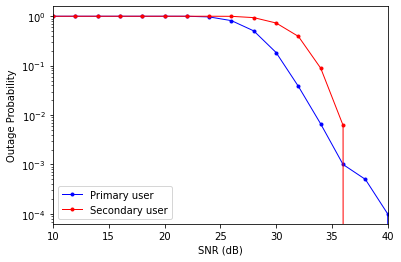

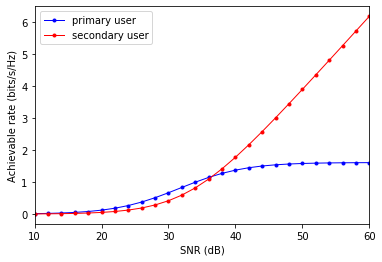

In [48]:

plot = "yes" 
if plot == "yes":
    # Outage probability
   # plt.semilogy(snr_dB, out_prob_mean, "go-", label="System", linewidth=2)
    plt.semilogy(snr_dB, out_prob_primary, "b.-", label="Primary user", linewidth=1)
    plt.semilogy(snr_dB, out_prob_secondary, "r.-", label="Secondary user", linewidth=1)
    plt.xlabel("SNR (dB)")
    plt.ylabel("Outage Probability")
    plt.legend(loc="lower left")
    plt.xlim(10, 40)

    # Average Achievable Rate of the users
    plt.figure()
    plt.plot(snr_dB, rate_mean_primary_user, "b.-", label="primary user", linewidth=1)
    plt.plot(
        snr_dB, rate_mean_secondary_user, "r.-", label="secondary user", linewidth=1
    )
    plt.xlim(10, 60)
    plt.xlabel("SNR (dB)")
    plt.ylabel("Achievable rate (bits/s/Hz)")
    plt.legend(loc="upper left")

    plt.show()
    